# Игра "Cookie Cats"

## О проекте

Cookie Cats популярная мобильная игра, разработанная Tactile Entertainment. Это классическая игра-головоломка в стиле "соедини три", в которой игрок должен соединить плитки одного цвета, чтобы очистить игровое поле и выиграть уровень.

По мере прохождения уровней игроки будут сталкиваться с воротами, которые заставляют их ждать некоторое время, прежде чем они смогут продвинуться, или совершить покупку в приложении. В этом проекте мы проанализируем результат A/B-теста, в котором первые ворота в Cookie Cats были перенесены с 30-го на 40-ой уровень. Для того, чтобы понять, хорошее это изменение или плохое, сравним такие пользовательские метрики, как наличие активности в 1-ый и 7-ой день после скачивания, а также посмотрим, в каком из случаев игроки склонные проходить больше уровней. 

## Предобработка и исследовательский анализ данных

In [101]:
# импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind, shapiro, mannwhitneyu
import warnings
warnings.filterwarnings("ignore")

Загрузим данные и проверим их на предмет наличия пропусков и дубликатов.

In [102]:
# создаём датасет из файла
df = pd.read_csv('cookie_cats.csv') 

In [103]:
# информация о датасете
print(df.info())

# число дубликатов
print(f'Число дубликатов {df.duplicated().sum()}')

# выводим первые 5 строк
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB
None
Число дубликатов 0


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


В данных нет дубликатов или пропусков. 

Информация о колонках:
- userid - id пользователя
- version - место расположения ворот - либо на 30-ом уровне, либо на 40-ом
- sum_gameround - число уровней, пройденных игроком за время эксперимента
- retention_1 - заходил ли пользователь в игру в 1-ый день после скачивания
- retention_7 - заходил ли пользователь в игру в 7-ой день после скачивания

Посмотрим, как распределены игроки между версиями и нет ли дубликатов среди id.

In [104]:
# проверяем, есть ли дубли id
print('Число дубликатов id:', df.duplicated(subset=['userid']).sum())
# смотрим, сколько игроков в таблице скачало одну и другую версию
print('Распределение игроков по версиям:', df.groupby('version')['userid'].count())

Число дубликатов id: 0
Распределение игроков по версиям: version
gate_30    44700
gate_40    45489
Name: userid, dtype: int64


Игроки распределены почти поровну между версиями игры.

Посмотрим, на боксплот суммы пройденных уровней, построенный по объединённым данным.

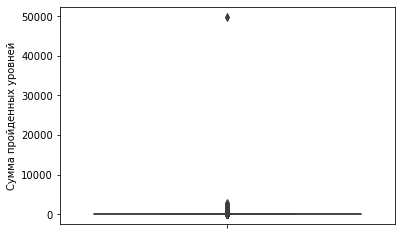

In [105]:
# строим ящик с усами для всех данных о пройденных уровнях
sns.boxplot(y=df['sum_gamerounds'])
plt.ylabel("Сумма пройденных уровней")
plt.show()

In [106]:
# выодим описание столбца с числом уровней
df['sum_gamerounds'].describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

Значение около 50 тысяч - явный выброс. Избавимся это этой строки. 

In [132]:
# удаляем строкус выбросом из таблицы
df = df.query('sum_gamerounds != 49854')

### Сравнение полных данных для обеих версий игры

Теперь построим такие боксплоты отдельно для каждой версии игры. Интересно, будет ли на них заметен какой-либо сдвиг.

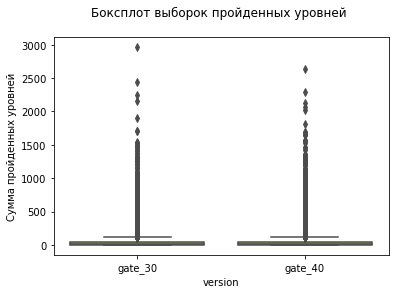

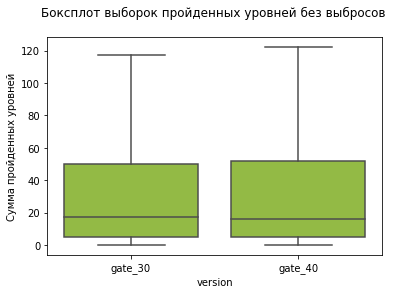

Описание выборки для версии с воротами после 30 уровня
count    44699.000000
mean        51.342111
std        102.057598
min          0.000000
25%          5.000000
50%         17.000000
75%         50.000000
max       2961.000000
Name: sum_gamerounds, dtype: float64
Описание выборки для версии с воротами после 40 уровня
count    45489.000000
mean        51.298776
std        103.294416
min          0.000000
25%          5.000000
50%         16.000000
75%         52.000000
max       2640.000000
Name: sum_gamerounds, dtype: float64


In [108]:
# строим ящик с усами данных о пройденных уровнях отдельно для каждой версии
sns.boxplot(x = df['version'], y = df['sum_gamerounds'], color='yellowgreen')
plt.ylabel("Сумма пройденных уровней")
plt.title('Боксплот выборок пройденных уровней \n')
plt.show()
# строим ящик с усами данных о пройденных уровнях отдельно для каждой версии, на этот раз без выбросов
sns.boxplot(x = df['version'], y = df['sum_gamerounds'], showfliers=False, color='yellowgreen')
plt.ylabel("Сумма пройденных уровней")
plt.title('Боксплот выборок пройденных уровней без выбросов \n')
plt.show()
# выодим описание столбца с числом уровней отдельно для каждой версии
print('Описание выборки для версии с воротами после 30 уровня', df.query('version == "gate_30"')['sum_gamerounds'].describe(), sep='\n')
print('Описание выборки для версии с воротами после 40 уровня', df.query('version == "gate_40"')['sum_gamerounds'].describe(), sep='\n')

Боксплоты выглядят довольно похоже, медианы на уровне 17, и 16 уровней, средние в обоих случаях составляют порядка 51 уровня, в обоих случаях не менее 75% выборки имеет значения < 53 уровней, не менее 25% игроков дошло в лучшем случае до 5 уровня.

Чтобы детальнее сравнить распределения, построим графики зависимости числа игроков, дошедших до каждого уровня, от номера этого уровня.

In [109]:
# группируем и считаем игроков в зависимости от числа пройденных уровней, создаём две таблицы 
df_30_plot = df.query('version == "gate_30"').groupby('sum_gamerounds')['userid'].count()
df_40_plot = df.query('version == "gate_40"').groupby('sum_gamerounds')['userid'].count()

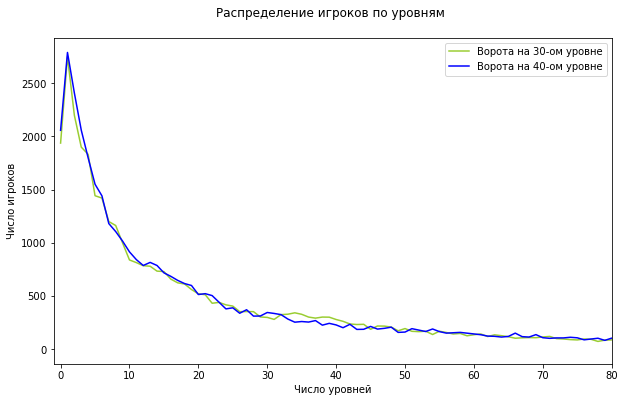

In [110]:

plt.figure(figsize=(10,6))
plt.xlim(-1, 80)
plt.plot(df_30_plot, color='yellowgreen')
plt.plot(df_40_plot, color='blue')
plt.title('Распределение игроков по уровням \n')
plt.legend(['Ворота на 30-ом уровне', 'Ворота на 40-ом уровне'])
plt.ylabel('Число игроков')
plt.xlabel('Число уровней')
plt.show()

Видно, что около 2000 игроков в каждом случае не играли в игру вообще, ещё больше остановилось после первого уровня, дальше число остановившихся на каждом следующем уровне почти всегда меньше предыдущего значение. Картина похожа на распределение Пуассона.

Теперь посчитаем, какая доля от общего числа игроков заходила в игру в 1-ый день и 7-ой дни после скачивания для каждой из версий игры.

In [111]:
# счтааем долю активных игроков в первый день после скачивания
print('Доля активных игроков в первый день после скачивания:')
df.groupby('version')['retention_1'].agg(['mean'])

Доля активных игроков в первый день после скачивания:


,mean
version,
gate_30,0.448198
gate_40,0.442283


В первый день играло меньше половины всех установивших игру. Разница между версиями около 0.6%.

In [112]:
# счтааем долю активных игроков в седьмой день после скачивания
print('Доля активных игроков в седьмой день после скачивания:')
df.groupby('version')['retention_7'].agg(['mean'])

Доля активных игроков в седьмой день после скачивания:


,mean
version,
gate_30,0.190183
gate_40,0.182000


В седьмой день осталось менее 20% установивших, новая версия снова отстаёт, теперь примерно на 0.8%. 

### Как число пройденных уровней зависит от того, заходил ли игрок в приложение в 1-ый и в 7-ой день после скачивания?

Мы разобьём датасет на 4 отдельных в зависимости от наличия активности в 1-ый и 7-ой дни. В первом датасете будут те, кто скачал приложение, но ни в 1-ый, ни в 7-ой день туда не зашёл, второй и третий будут содержать данные о тех, кто зашёл в один из этих дней, четвёртый - о тех, кто заходил в оба дня.

In [113]:
# создаём описанные выше таблицы
df_none = df.query('~retention_1 and ~retention_7')['sum_gamerounds']
df_1 = df.query('retention_1 and ~retention_7')['sum_gamerounds']
df_7 = df.query('~retention_1 and retention_7')['sum_gamerounds']
df_17 = df.query('retention_1 and retention_7')['sum_gamerounds']
# собираем их в единый датафрейм и выводим информацию о нём
df_rounds_ret = pd.DataFrame({'none':df_none, 'only_1':df_1, 'only_7':df_7, 'both':df_17})
# собираем в таблицу данные о доле каждой группы
df_rounds_ret_share = pd.Series({'none':len(df_none)/len(df), 'only_1':len(df_1)/len(df), 
                        'only_7':len(df_7)/len(df), 'both':len(df_17)/len(df)})
print(df_rounds_ret.info(), end='\n\n')
print('Доля каждой группы от общего числа')
display(df_rounds_ret_share)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90188 entries, 0 to 90188
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   none    46437 non-null  float64
 1   only_1  26971 non-null  float64
 2   only_7  3598 non-null   float64
 3   both    13182 non-null  float64
dtypes: float64(4)
memory usage: 3.4 MB
None

Доля каждой группы от общего числа


none      0.514891
only_1    0.299053
only_7    0.039894
both      0.146161
dtype: float64

Мы видим, что около половины всех скачавших приложение не зашли ни в один из двух дней, меньше трети - только в первый из двух, постоянных игроков менее 15%. 

Посмотрим на боксплоты выброк числа уровней для каждой из групп.

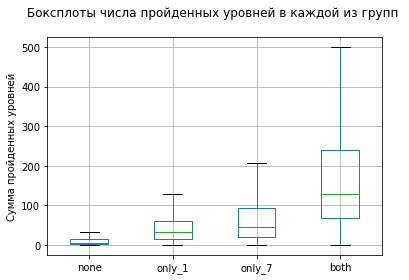

In [114]:
# боксплоты с выборками числа уровней для каждой группы
df_rounds_ret.boxplot(showfliers=False)
plt.ylabel("Сумма пройденных уровней")
plt.title('Боксплоты числа пройденных уровней в каждой из групп \n')
plt.show()

Как и следовало ожидать, самый заметный прогресс по уровням у тех, кто заходил в игру в оба дня, а у тех, кто зашёл только в 7-ой он больше, чем у тех, кто зашёл в только в 1-ый.

### Сравнение набров игроков, дошедших до 30-го уровня

Поскольку первые ворота в контрольной версии игры появляются только после 30-го уровня, а в альтернативной - и того позже, реальная разница между двумя версиями должна появляться только после достижения 30 уровня, до этого игроки обеих версий находятся в одинаковых условиях.

Создадим новый датасет с только интересующими нас игроками и проведём с ним аналогичный анализ.

In [115]:
#отсеим часть игроков и выведем параметры таблицы
df_upd = df.query('sum_gamerounds >= 30')
df_upd.shape

(33268, 5)

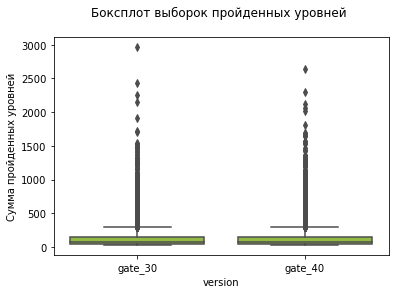

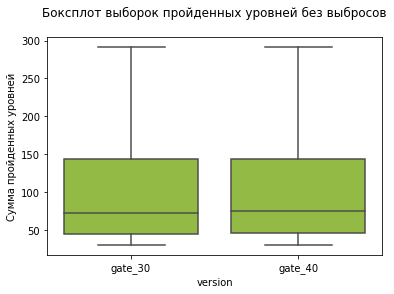

Описание выборки для версии с воротами после 30 уровня
count    16655.000000
mean       122.092645
std        140.954996
min         30.000000
25%         44.000000
50%         72.000000
75%        143.000000
max       2961.000000
Name: sum_gamerounds, dtype: float64
Описание выборки для версии с воротами после 40 уровня
count    16613.000000
mean       124.466502
std        143.779800
min         30.000000
25%         46.000000
50%         75.000000
75%        144.000000
max       2640.000000
Name: sum_gamerounds, dtype: float64


In [116]:
# строим ящик с усами данных о пройденных уровнях отдельно для каждой версии
sns.boxplot(x = df_upd['version'], y = df_upd['sum_gamerounds'], color='yellowgreen')
plt.ylabel("Сумма пройденных уровней")
plt.title('Боксплот выборок пройденных уровней \n')
plt.show()
# строим ящик с усами данных о пройденных уровнях отдельно для каждой версии без выбросов
sns.boxplot(x = df_upd['version'], y = df_upd['sum_gamerounds'], showfliers=False, color='yellowgreen')
plt.ylabel("Сумма пройденных уровней")
plt.title('Боксплот выборок пройденных уровней без выбросов\n')
plt.show()
#выводим описание выборок
print('Описание выборки для версии с воротами после 30 уровня', df_upd.query('version == "gate_30"')['sum_gamerounds'].describe(), sep='\n')
print('Описание выборки для версии с воротами после 40 уровня', df_upd.query('version == "gate_40"')['sum_gamerounds'].describe(), sep='\n')

Даже после отделения большой части данных эти наборы выглядят очень похоже, хотя стоит отметить сдвиг некоторых статистик второго набора (первые ворота на 40-ом уровне) вперёд на 1-2 уровня по сравнению с первым (первый квартиль, медиана, третий квартиль, среднее).

Посчитаем, какая доля игроков заходила в игру в 1-ый день и 7-ой дни после скачивания для каждой из версий игры.

In [117]:
# считаем долю активных игроков в первый день после скачивания
print('Доля активных игроков в первый день после скачивания:')
df_upd.groupby('version')['retention_1'].agg(['mean'])

Доля активных игроков в первый день после скачивания:


,mean
version,
gate_30,0.801021
gate_40,0.801842


Как и следовало ожидать, среди достигших аж 30-ый уровень доля активных в первый день будет заметно выше. Для второй версии видим маленький перевес менее 0.1%.

In [118]:
# считаем долю активных игроков в седьмой день после скачивания
print('Доля активных игроков в седьмой день после скачивания:')
df_upd.groupby('version')['retention_7'].agg(['mean'])

Доля активных игроков в седьмой день после скачивания:


,mean
version,
gate_30,0.438727
gate_40,0.430025


По сравнению с первым днём число активных игроков упало в два раза. В случае контрольной версии почти на 1% больше игроков.

## A/B-тестирование

Поскольку до достижения 30-го уровня игроки обеих групп находятся в одинаковых условиях, будем анализировать данные только о тех, кто дошёл до 30-го уровня.

### Активность в 1-ый день после скачивания

In [119]:
# группируем игроков по версии, считаем среднее, число строк и сумму по столбцу с данными об активности в первый день
df_ret1 = df_upd.groupby('version')['retention_1'].agg(['mean', 'count', 'sum'])
display(df_ret1)

,mean,count,sum
version,,,
gate_30,0.801021,16655,13341
gate_40,0.801842,16613,13321


Для проверки гипотезы о равенстве долей игроков, заходивших в игру в первый день, воспользуемся предположением о независимости и одинаковой распределённости отдельных наблюдений. Тогда, согласно ЦПТ, мы сможем считать эту величину нормально распределённой.
Для проверки гипотез используем тест на равенство долей. 
Сформулируем нулевую и альтернативную гипотезы:

*H0: p40 = p30*

*H1: p40 > p30*

Зададим уровень значимости 5%.

In [120]:
# считаем значение статистики и p-value
zstat, pvalue = proportions_ztest(df_ret1['sum'].values, df_ret1['count'].values, alternative='smaller')
print(f'Значение z-статистики: {zstat:.3}, p-value: {pvalue:.3}')

Значение z-статистики: -0.188, p-value: 0.426


P-value оказался заметно выше уровня значимости, следовательно, мы не можем отвергнуть нулевую гипотезу о равенстве долей.

### Активность в 7-ой день после скачивания

In [121]:
# группируем игроков по версии, считаем среднее, число строк и сумму по столбцу с данными об активности в седбмой день
df_ret7 = df_upd.groupby('version')['retention_7'].agg(['mean', 'count', 'sum'])
display(df_ret7)

,mean,count,sum
version,,,
gate_30,0.438727,16655,7307
gate_40,0.430025,16613,7144


Как и в предыдущем случае, для проверки гипотез используем тест на равенство долей. 
Сформулируем нулевую и альтернативную гипотезы:

*H0: p40 = p30*

*H1: p40 < p30*

Зададим уровень значимости alpha = 0.05.

In [122]:
# считаем значение статистики и p-value
zstat, pvalue = proportions_ztest(df_ret7['sum'].values, df_ret7['count'].values, alternative='larger')
print(f'Значение z-статистики: {zstat:.3}, p-value: {pvalue:.3}')

Значение z-статистики: 1.6, p-value: 0.0547


P-value оказался выше уровня значимости, не можем отвергнуть нулевую гипотезу о равенстве долей.

### Число пройденных уровней

Теперь мы хотим понять, есть ли сдвиг между распределениями числа пройденных уровней, или обе выборки можно считать взятыми из одной генеральной совокупности. С помощью критерия Шапиро-Уилка, как наиболее мощного критерия для проверки нормальности, проверим, можно ли считать генральные совокупности нормально распределёнными. Если гипотеза о нормальности не будет отвергнута, для проверки гипотезы об однородности воспользуемся критерием Стьюдента, в противном случае воспользуемся непараметрическим критерием Манна-Уитни.

Для обеих выброк нулевая и альтернативная гипотезы будут выглядеть одинаково:

*H0: ГС нормально распределена*

*H1: ГС имеет другой закон распределения*

Зададим уровень значимости 5%.

In [123]:
# считаем значение статистики и p-value для обеих выброк
statistic, pvalue = shapiro(df_upd.query('version == "gate_30"')['sum_gamerounds'].values)
print(f'Значение статистики для первой выборки: {statistic:.3}, p-value: {pvalue:.3}')

statistic, pvalue = shapiro(df_upd.query('version == "gate_40"')['sum_gamerounds'].values)
print(f'Значение статистики для второй выборки: {statistic:.3}, p-value: {pvalue:.3}')

Значение статистики для первой выборки: 0.607, p-value: 0.0
Значение статистики для второй выборки: 0.6, p-value: 0.0


Отвергаем гипотезу о нормальной распределённости для обеих ГС.

Стало быть, для проверки гипотезы о наличии сдвига используем непараметрический критерий Манна-Уитни.
Сформулируем нулевую и альтернативную гипотезы:

*H0: две генеральные совокупности одинаково распределены*

*H1: две генеральные совокупности имеют разные функции распределения*

Зададим уровень значимости 5%.

In [129]:
# считаем значение статистики и p-value для обеих выброк
statistic, pvalue = mannwhitneyu(df_upd.query('version == "gate_30"')['sum_gamerounds'].values, 
                                 df_upd.query('version == "gate_40"')['sum_gamerounds'].values)
print(f'Значение u-статистики: {statistic:.3}, p-value: {pvalue:.3}')

Значение u-статистики: 1.35e+08, p-value: 0.000104


P-value значительно ниже уровня значимости, отвергаем нулевую гипотезу и считаем, что выборки взяты из разных распределений. И как мы видели на боксплотах, характеристики положения второй выборки действительно немного сдвинуты вправо по сравнению с характеристиками положения контрольной выборки.

## Выводы

1) Первое, что обращает на себя внимание: более половины игроков не заходили в игру ни в первый, ни седьмой день после скачивания, второе - больше половины прошли за 7 дней не более 20 уровней, а значит, не дошли даже до первых ворот.

2) Как и следовало ожидать, более активные игроки показывают заметно лучший прогресс в прохождении уровней, очевидный вывод: важно мотивировать пользователей играть как можно чаще. 

3) Как следует из результатов тестирования, перемещение ворот с 30-го на 40-ой уровень почти не влияет на уровень активности игроков в 1-ый или 7-ой день после скачивания.

4) Был заметен небольшой сдвиг вправо в распределении числа пройденных уровней в версии с воротами на 40-ом уровне по сравнению с контрольной версией.

Дополнительно было бы интересно проанализировать, сколько игроков заплатило за преодоление ворот в каждой из версии, но, к сожалению, мы не располагаем этими данными.